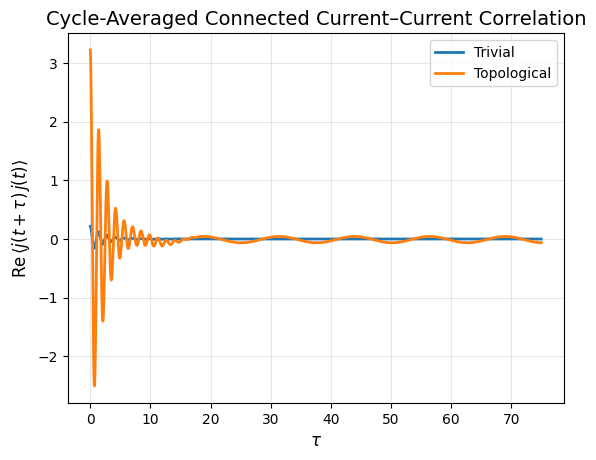

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

class SSHCurrentCorrelation:
#parameters 
    def __init__(
        self,
        t1=2.0,
        t2=1.0,
        A=0.2,
        omega0=0.501,
        tau_diss=1.5,
        k=np.pi/2): #fixed momentum k

        #storage
        self.t1 = t1
        self.t2 = t2
        self.A = A
        self.omega0 = omega0
        self.tau_diss = tau_diss
        self.k = k
        self.T = 2*np.pi / omega0
        self.compute_berry_connection()
#time-dependent drive A(t) = Asin(omega*t)
    def A_field(self, t):
        return self.A * np.sin(self.omega0 * t)
    def E_plus(self):
        return np.sqrt(
            self.t1**2 + self.t2**2 +
            2*self.t1*self.t2*np.cos(self.k))
#slope of band
    def dE_dk(self):
        return -self.t1*self.t2*np.sin(self.k) / self.E_plus()
    def compute_berry_connection(self):
        cosk = np.cos(self.k)
        num = self.t2 * (self.t2 + self.t1*cosk)
        den = self.t1**2 + self.t2**2 + 2*self.t1*self.t2*cosk
        self.A_pp = 0.5 * num / den
#Build of 2x2 time-dependent hamiltonian at time t
    def H_matrix(self, t):
        A = self.A_field(t)
        E = self.E_plus()
        dE = self.dE_dk()

        hz = E - dE*np.sin(A) - 2*E*self.A_pp*(1 - np.cos(A))
        hy = dE*(1 - np.cos(A)) - 2*E*self.A_pp*np.sin(A)

        return np.array([[hz, -1j*hy],
                         [1j*hy, -hz]], dtype=complex)

    def current_operator(self, t):
        A = self.A_field(t)
        denom = self.E_plus()

        j_pp = self.t2*(self.t2*np.sin(A) - self.t1*np.sin(self.k - A)) / denom
        j_mm = -j_pp
        j_pm = -1j*self.t2*(self.t2*np.cos(A) + self.t1*np.cos(self.k - A)) / denom
        j_mp = -j_pm

        return np.array([[j_pp, j_pm],
                         [j_mp, j_mm]], dtype=complex)
#
    def dissipator(self, rho):
        sm = np.array([[0,0],[1,0]], dtype=complex)
        sp = np.array([[0,1],[0,0]], dtype=complex)
        gamma = 1 / self.tau_diss
        return gamma * (sm@rho@sp - 0.5*(sp@sm@rho + rho@sp@sm))

    def rho_dot(self, t, rho_vec):
        rho = rho_vec.reshape((2,2))
        H = self.H_matrix(t)
        comm = -1j*(H@rho - rho@H)
        return (comm + self.dissipator(rho)).flatten()
#take steady state
    def steady_state(self, t_warmup=200.0):
        rho0 = np.array([[0,0],[0,1]], dtype=complex).flatten()
        sol = solve_ivp(
            self.rho_dot,
            [0, t_warmup],
            rho0,
            rtol=1e-8,
            atol=1e-10
        )
        return sol.y[:,-1].reshape((2,2))
    
    def current_correlation_cycle_avg(
        self,
        tau_max=75.0,
        n_tau=1500,
        n_phase=8
    ):
        rho_ss = self.steady_state()
        tau_grid = np.linspace(0, tau_max, n_tau)
        C_avg = np.zeros(n_tau, dtype=complex)

        t_phases = np.linspace(0, self.T, n_phase, endpoint=False)

        for t0 in t_phases:
            j_t = self.current_operator(t0)
            j_t_exp = np.trace(j_t @ rho_ss)
            rho0 = (j_t @ rho_ss).flatten()

            def rho_tau_dot(tau, rho_vec):
                rho = rho_vec.reshape((2,2))
                H = self.H_matrix(t0 + tau)
                comm = -1j*(H@rho - rho@H)
                return (comm + self.dissipator(rho)).flatten()

            sol = solve_ivp(
                rho_tau_dot,
                [0, tau_max],
                rho0,
                t_eval=tau_grid,
                rtol=1e-7,
                atol=1e-9
            )

            for i, tau in enumerate(tau_grid):
                rho_tau = sol.y[:,i].reshape((2,2))
                j_tau = self.current_operator(t0 + tau)
                j_tau_exp = np.trace(j_tau @ rho_ss)
                C_avg[i] += np.trace(j_tau @ rho_tau) - j_tau_exp*j_t_exp

        return tau_grid, C_avg / n_phase

#triv case 
ssh_triv = SSHCurrentCorrelation(t1=2.0, t2=1.0)
#run tau values, cycle averaged connected correlation (triv)
tau_triv, Cjj_triv = ssh_triv.current_correlation_cycle_avg()
Cjj_triv = Cjj_triv - np.mean(Cjj_triv[-200:])

#same but for topological case 
ssh_topo = SSHCurrentCorrelation(t1=1.0, t2=2.0)
#run tau values, cycle averaged connected correlation (topological)
tau_topo, Cjj_topo = ssh_topo.current_correlation_cycle_avg()
Cjj_topo = Cjj_topo - np.mean(Cjj_topo[-200:])

plt.plot(tau_triv, Cjj_triv.real, label='Trivial', linewidth=2)
plt.plot(tau_topo, Cjj_topo.real, label='Topological', linewidth=2)
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'$\mathrm{Re}\,\langle j(t+\tau)\,j(t)\rangle$', fontsize=12)
plt.title('Cycle-Averaged Connected Current–Current Correlation', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


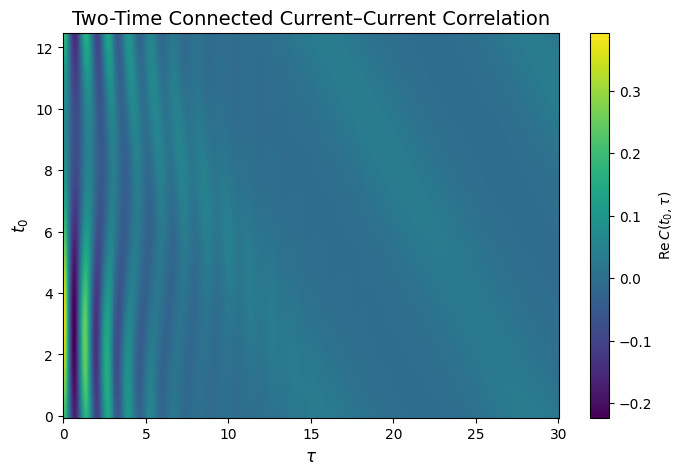

In [ ]:
ssh = SSHCurrentCorrelation(t1=2.0, t2=1.0)  #trivial case

tau_max = 30.0
n_tau = 500
n_phase = 100 

rho_ss = ssh.steady_state()
tau_grid = np.linspace(0, tau_max, n_tau)
t_phases = np.linspace(0, ssh.T, n_phase, endpoint=False)

C_matrix = np.zeros((n_phase, n_tau), dtype=complex)

#Compute C(t0, tau)
for i, t0 in enumerate(t_phases):
    j_t = ssh.current_operator(t0)
    j_t_exp = np.trace(j_t @ rho_ss)
    rho0 = (j_t @ rho_ss).flatten()

    def rho_tau_dot(tau, rho_vec):
        rho = rho_vec.reshape((2,2))
        H = ssh.H_matrix(t0 + tau)
        comm = -1j*(H@rho - rho@H)
        return (comm + ssh.dissipator(rho)).flatten()

    sol = solve_ivp(
        rho_tau_dot,
        [0, tau_max],
        rho0,
        t_eval=tau_grid,
        rtol=1e-7,
        atol=1e-9
    )

    for j, tau in enumerate(tau_grid):
        rho_tau = sol.y[:,j].reshape((2,2))
        j_tau = ssh.current_operator(t0 + tau)
        j_tau_exp = np.trace(j_tau @ rho_ss)
        C_matrix[i,j] = np.trace(j_tau @ rho_tau) - j_tau_exp*j_t_exp

plt.figure(figsize=(8,5))
plt.pcolormesh(tau_grid, t_phases, C_matrix.real, shading='auto', cmap='viridis')
plt.colorbar(label=r'Re$\,C(t_0, \tau)$')
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'$t_0$', fontsize=12)
plt.title('Two-Time Connected Current–Current Correlation', fontsize=14)
plt.show()


<>:197: SyntaxWarning: invalid escape sequence '\o'
<>:203: SyntaxWarning: invalid escape sequence '\o'
<>:197: SyntaxWarning: invalid escape sequence '\o'
<>:203: SyntaxWarning: invalid escape sequence '\o'
C:\Users\zimme\AppData\Local\Temp\ipykernel_16916\30725688.py:197: SyntaxWarning: invalid escape sequence '\o'
  plt.title("Trivial  $\overline{D}(\\tau)$")
C:\Users\zimme\AppData\Local\Temp\ipykernel_16916\30725688.py:203: SyntaxWarning: invalid escape sequence '\o'
  plt.title("Topological  $\overline{D}(\\tau)$")


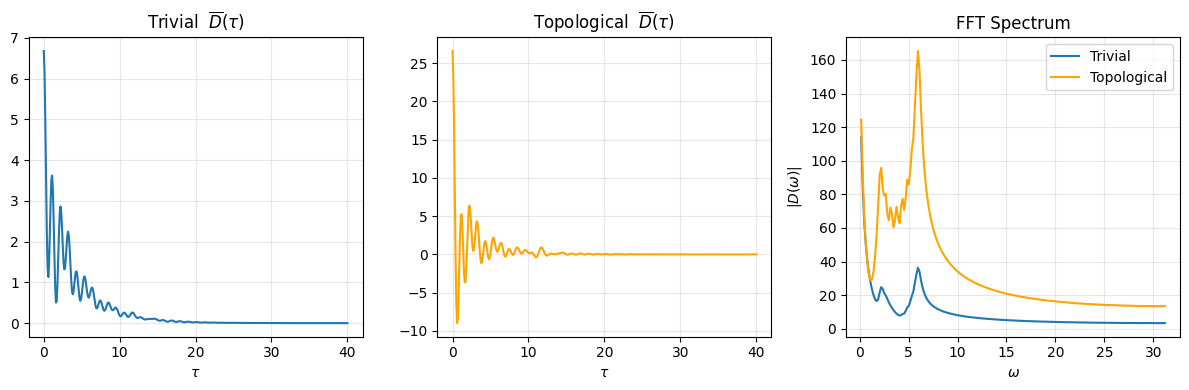

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq


class SSHCurrentCorrelationFast:
    def __init__(
        self,
        t1=2.0,
        t2=1.0,
        A=0.2,
        omega0=0.501,
        tau_diss=4,
        nk=21,
        n_phase=50,
        n_tau=400,
        tau_max=40.0):
        #store parameters 
        self.t1 = t1
        self.t2 = t2
        self.A = A
        self.omega0 = omega0
        self.tau_diss = tau_diss
        self.nk = nk
        self.n_phase = n_phase
        self.n_tau = n_tau
        self.tau_max = tau_max
#define k-period and drive period 
        self.k_grid = np.linspace(-np.pi, np.pi, nk, endpoint=False)
        self.T = 2 * np.pi / omega0
#pre comp. k-dependent quantities 
        self.precompute_k_dependent()

    def precompute_k_dependent(self):
        self.E_plus_vals = np.zeros(self.nk)
        self.dE_dk_vals = np.zeros(self.nk)
        self.A_pp_vals = np.zeros(self.nk)
#loop over k
        for i, k in enumerate(self.k_grid):
            cosk = np.cos(k)
            sink = np.sin(k)

            E = np.sqrt(self.t1**2 + self.t2**2 + 2*self.t1*self.t2*cosk)
            self.E_plus_vals[i] = E
            self.dE_dk_vals[i] = -self.t1*self.t2*sink/E if E > 1e-10 else 0

            num = self.t2 * (self.t2 + self.t1*cosk)
            den = self.t1**2 + self.t2**2 + 2*self.t1*self.t2*cosk
            self.A_pp_vals[i] = 0.5 * num / den if den > 1e-10 else 0
    def A_field(self, t):
        return self.A * np.sin(self.omega0 * t) #time dependent drive A(t)
#2x2 Hamiltonian H(t,k)
    def H_matrix(self, t, k_idx):
        A = self.A_field(t)
        E = self.E_plus_vals[k_idx]
        dE = self.dE_dk_vals[k_idx]
        A_pp = self.A_pp_vals[k_idx]

        sinA = np.sin(A)
        cosA = np.cos(A)

        hz = E - dE*sinA - 2*E*A_pp*(1 - cosA)
        hy = dE*(1 - cosA) - 2*E*A_pp*sinA

        return np.array([[hz, -1j*hy],
                         [1j*hy, -hz]], dtype=complex)
#current operator j(t,k)
    def current_operator(self, t, k_idx):
        k = self.k_grid[k_idx]
        A = self.A_field(t)
        denom = self.E_plus_vals[k_idx]

        sinA = np.sin(A)
        cosA = np.cos(A)
        sinkA = np.sin(k - A)
        coskA = np.cos(k - A)

        j_pp = self.t2*(self.t2*sinA - self.t1*sinkA)/denom
        j_pm = -1j*self.t2*(self.t2*cosA + self.t1*coskA)/denom

        return np.array([[j_pp, j_pm],
                         [-j_pm, -j_pp]], dtype=complex)

    def dissipator(self, rho):
        gamma = 1 / self.tau_diss

        term1 = np.array([[rho[1,1], 0],
                          [0, 0]], dtype=complex)

        term2 = -0.5 * np.array([[2*rho[0,0], 2*rho[0,1]],
                                 [2*rho[1,0], 0]], dtype=complex)

        return gamma * (term1 + term2)

    def compute_steady_state(self, k_idx, t_warmup=50.0):
        rho0 = np.array([[0,0],[0,1]], dtype=complex).flatten()
        def rho_dot(t, rho_vec):
            rho = rho_vec.reshape((2,2))
            H = self.H_matrix(t, k_idx)
            comm = -1j*(H@rho - rho@H)
            return (comm + self.dissipator(rho)).flatten()
        sol = solve_ivp(
            rho_dot, [0, t_warmup], rho0,
            rtol=1e-6, atol=1e-8)
        return sol.y[:, -1].reshape((2,2))
    def compute_periodic_current(self, k_idx, rho_ss):
        t_grid = np.linspace(0, self.T, self.n_phase, endpoint=False)
        j_vals = np.zeros(self.n_phase)

        for i, t in enumerate(t_grid):
            j_vals[i] = np.trace(self.current_operator(t, k_idx) @ rho_ss).real

        return t_grid, j_vals
    def compute_correlation_t0(self, t0, k_idx, rho_ss, t_per, j_per, tau_grid):
        j_t0 = self.current_operator(t0, k_idx)
        rho0 = (j_t0 @ rho_ss).flatten()
        def j_bar(t):
            return np.interp(t % self.T, t_per, j_per)
        def rho_tau_dot(tau, rho_vec):
            rho = rho_vec.reshape((2,2))
            H = self.H_matrix(t0 + tau, k_idx)
            comm = -1j*(H@rho - rho@H)
            return (comm + self.dissipator(rho)).flatten()
        sol = solve_ivp(
            rho_tau_dot, [0, self.tau_max], rho0,
            t_eval=tau_grid, rtol=1e-6, atol=1e-8)

        Dk = np.zeros(len(tau_grid), dtype=complex)

        for i, tau in enumerate(tau_grid):
            rho_tau = sol.y[:, i].reshape((2,2))
            j_tau = self.current_operator(t0 + tau, k_idx)
            C = np.trace(j_tau @ rho_tau)
            Dk[i] = C - j_bar(t0)*np.trace(j_tau @ rho_ss)
        return Dk
    #sum over t0, sum over k, normalize by 2pi
    def compute_all_correlations(self):
        tau_grid = np.linspace(0, self.tau_max, self.n_tau)
        sum_Dk = np.zeros(self.n_tau, dtype=complex)
#comp steady state for every k
        steady_states = [self.compute_steady_state(k) for k in range(self.nk)]

        for k_idx in range(self.nk):
            rho_ss = steady_states[k_idx]
            t_per, j_per = self.compute_periodic_current(k_idx, rho_ss)
            t_phases = np.linspace(0, self.T, self.n_phase, endpoint=False) #average over drive phase t0

            Dk_k = np.zeros(self.n_tau, dtype=complex)
            for t0 in t_phases:
                Dk_k += self.compute_correlation_t0(
                    t0, k_idx, rho_ss, t_per, j_per, tau_grid)
#normalize phase average and k integral
            sum_Dk += Dk_k / (self.n_phase * 2*np.pi)

        return tau_grid, sum_Dk.real

triv = SSHCurrentCorrelationFast(t1=2.0, t2=1.0)
topo = SSHCurrentCorrelationFast(t1=1.0, t2=2.0)

tau_triv, D_triv = triv.compute_all_correlations()
tau_topo, D_topo = topo.compute_all_correlations()

#FFT
dt = tau_triv[1] - tau_triv[0]
omega = 2*np.pi*fftfreq(len(tau_triv), d=dt)

Domega_triv = np.abs(fft(D_triv))
Domega_topo = np.abs(fft(D_topo))

mask = omega > 0

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(tau_triv, D_triv)
plt.title("Trivial  $\overline{D}(\\tau)$")
plt.xlabel(r"$\tau$")
plt.grid(alpha=0.3)

plt.subplot(1,3,2)
plt.plot(tau_topo, D_topo, color="orange")
plt.title("Topological  $\overline{D}(\\tau)$")
plt.xlabel(r"$\tau$")
plt.grid(alpha=0.3)

plt.subplot(1,3,3)
plt.plot(omega[mask], Domega_triv[mask], label="Trivial")
plt.plot(omega[mask], Domega_topo[mask], label="Topological", color="orange")
plt.xlabel(r"$\omega$")
plt.ylabel(r"$|D(\omega)|$")
plt.title("FFT Spectrum")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


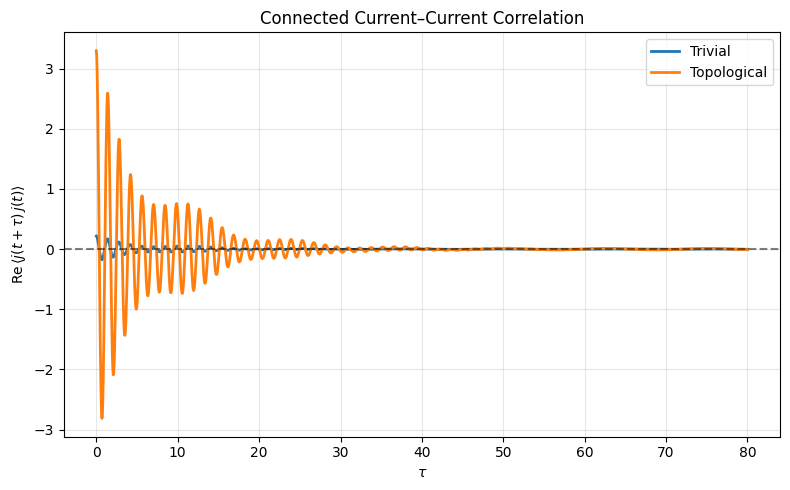

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


class SSHCurrentCorrelation:
    def __init__(
        self,
        t1=2.0,
        t2=1.0,
        A=0.2,
        omega0=0.501,
        tau_diss=4,
        k=np.pi / 2):
        self.t1 = t1
        self.t2 = t2
        self.A = A
        self.omega0 = omega0
        self.tau_diss = tau_diss
        self.k = k
        self.T = 2 * np.pi / omega0
        self.compute_berry_connection()

    def A_field(self, t):
        return self.A * np.sin(self.omega0 * t)

    def E_plus(self):
        return np.sqrt(
            self.t1**2 + self.t2**2 +
            2 * self.t1 * self.t2 * np.cos(self.k))

    def dE_dk(self):
        return -self.t1 * self.t2 * np.sin(self.k) / self.E_plus()

    def compute_berry_connection(self):
        cosk = np.cos(self.k)
        num = self.t2 * (self.t2 + self.t1 * cosk)
        den = self.t1**2 + self.t2**2 + 2 * self.t1 * self.t2 * cosk
        self.A_pp = 0.5 * num / den

    def H_matrix(self, t):
        A = self.A_field(t)
        E = self.E_plus()
        dE = self.dE_dk()

        hz = E - dE * np.sin(A) - 2 * E * self.A_pp * (1 - np.cos(A))
        hy = dE * (1 - np.cos(A)) - 2 * E * self.A_pp * np.sin(A)

        return np.array([[hz, -1j * hy],
                         [1j * hy, -hz]], dtype=complex)

    def current_operator(self, t):
        A = self.A_field(t)
        denom = self.E_plus()

        j_pp = self.t2 * (self.t2 * np.sin(A) - self.t1 * np.sin(self.k - A)) / denom
        j_mm = -j_pp
        j_pm = -1j * self.t2 * (self.t2 * np.cos(A) + self.t1 * np.cos(self.k - A)) / denom
        j_mp = -j_pm

        return np.array([[j_pp, j_pm],
                         [j_mp, j_mm]], dtype=complex)

    def dissipator(self, rho):
        sm = np.array([[0, 0], [1, 0]], dtype=complex)
        sp = np.array([[0, 1], [0, 0]], dtype=complex)
        gamma = 1 / self.tau_diss
        return gamma * (sm @ rho @ sp - 0.5 * (sp @ sm @ rho + rho @ sp @ sm))

    def rho_dot(self, t, rho_vec):
        rho = rho_vec.reshape((2, 2))
        H = self.H_matrix(t)
        comm = -1j * (H @ rho - rho @ H)
        return (comm + self.dissipator(rho)).flatten()

    def steady_state(self, t_warmup=200.0):
        rho0 = np.array([[0, 0], [0, 1]], dtype=complex).flatten()
        sol = solve_ivp(
            self.rho_dot,
            [0, t_warmup],
            rho0,
            rtol=1e-8,
            atol=1e-10)
        return sol.y[:, -1].reshape((2, 2))

    def current_correlation_cycle_avg(
        self,
        tau_max=80.0,
        n_tau=1500,
        n_phase=200):
        rho_ss = self.steady_state()
        tau_grid = np.linspace(0, tau_max, n_tau)
        C_avg = np.zeros(n_tau)

        t_phases = np.linspace(0, self.T, n_phase, endpoint=False)

        for t0 in t_phases:
            j_t = self.current_operator(t0)
            rho0 = (j_t @ rho_ss).flatten()

            def rho_tau_dot(tau, rho_vec):
                rho = rho_vec.reshape((2, 2))
                H = self.H_matrix(t0 + tau)
                comm = -1j * (H @ rho - rho @ H)
                return (comm + self.dissipator(rho)).flatten()

            sol = solve_ivp(
                rho_tau_dot,
                [0, tau_max],
                rho0,
                t_eval=tau_grid,
                rtol=1e-7,
                atol=1e-9)

            for i, tau in enumerate(tau_grid):
                rho_tau = sol.y[:, i].reshape((2, 2))
                j_tau = self.current_operator(t0 + tau)
                C_avg[i] += np.trace(j_tau @ rho_tau).real

        C_avg /= n_phase

        tail = int(0.85 * n_tau)        
        C_offset = np.mean(C_avg[tail:])
        C_avg -= C_offset

        return tau_grid, C_avg


ssh_triv = SSHCurrentCorrelation(t1=2.0, t2=1.0)
tau_triv, C_triv = ssh_triv.current_correlation_cycle_avg()

ssh_topo = SSHCurrentCorrelation(t1=1.0, t2=2.0)
tau_topo, C_topo = ssh_topo.current_correlation_cycle_avg()

plt.figure(figsize=(8, 5))
plt.plot(tau_triv, C_triv, label="Trivial", linewidth=2)
plt.plot(tau_topo, C_topo, label="Topological", linewidth=2)
plt.axhline(0, color="k", linestyle="--", alpha=0.5)

plt.xlabel(r"$\tau$")
plt.ylabel(r'$\mathrm{Re}\,\langle j(t+\tau)\,j(t)\rangle$')
plt.title("Connected Current–Current Correlation")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()